In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_6599/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt, log
sns.set_style("darkgrid")

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  

In [3]:
_prints = False

In [4]:
local = True

path = '../data/' 
hotels = pd.read_csv('../data/features_hotels.csv') # à tester, sans ces données

if local : 
    data = pd.read_csv(path+"data.csv")
else :
    url = 'https://drive.google.com/file/d/10sNct4HjylkBudNAQNfvMpI7qgvsspwj/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    data = pd.read_csv(path)
    
data = data.merge(hotels, on=['hotel_id','city'])
data_test = pd.read_csv(path+'test_set.csv') # ignore index 
data_test['request_number'] = 0
data_test = data_test.merge(hotels, on=['hotel_id','city']) 

for avatar in np.unique(data_test['avatar_id']):
    data_test['request_number'].loc[data_test['avatar_id'] == avatar] = data_test['order_requests'].loc[data_test['avatar_id']== avatar] - min(data_test['order_requests'].loc[data_test['avatar_id']== avatar]-1)

data.head()

/tmp/ipykernel_6599/2280392610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['request_number'].loc[data_test['avatar_id'] == avatar] = data_test['order_requests'].loc[data_test['avatar_id']== avatar] - min(data_test['order_requests'].loc[data_test['avatar_id']== avatar]-1)


,city,date,language,mobile,request_number,avatar_id,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,valletta,2,bulgarian,1,1,134,55,109,10,Boss Western,Boss Western,1,0,0
1,valletta,32,bulgarian,1,1,167,55,100,49,Boss Western,Boss Western,1,0,0
2,valletta,32,hungarian,0,1,179,55,100,49,Boss Western,Boss Western,1,0,0
3,valletta,5,danish,1,1,197,55,129,0,Boss Western,Boss Western,1,0,0
4,valletta,36,danish,1,1,203,55,110,64,Boss Western,Boss Western,1,0,0


In [5]:
np.unique(data_test['request_number'])

array([1, 2, 3, 4])

In [6]:
data.shape

(281393, 14)

In [7]:
data.dtypes

city               object
date                int64
language           object
mobile              int64
request_number      int64
avatar_id           int64
hotel_id            int64
price               int64
stock               int64
group              object
brand              object
parking             int64
pool                int64
children_policy     int64
dtype: object

In [8]:
for col in ['city', 'language', 'avatar_id', 'hotel_id', 'group', 'brand','children_policy'] :
    data[col] = pd.Categorical(data[col],ordered=False)
    data_test[col] = pd.Categorical(data_test[col],ordered=False)
    
data.dtypes

city               category
date                  int64
language           category
mobile                int64
request_number        int64
avatar_id          category
hotel_id           category
price                 int64
stock                 int64
group              category
brand              category
parking               int64
pool                  int64
children_policy    category
dtype: object

In [9]:
colQT = ['request_number', 'stock', 'date']

In [10]:
if _prints :
    plt.figure()
    sns.histplot(data['price'])
    plt.show()

In [11]:
if _prints :
    plt.figure()
    sns.histplot(data['price'].map(lambda x: x**(1/3)))
    plt.show()

In [12]:
transfo = True
if transfo :
    data['SRprice'] = data['price'].map(lambda x: x**(1/3))

In [13]:
if _prints :
    for col in data.columns:
        plt.figure(figsize=(8,3))
        sns.histplot(data[col])
        plt.xticks(rotation=45)
        plt.show()

In [14]:
if _prints :
    for col in data_test.columns:
        plt.figure(figsize=(8,3))
        sns.histplot(data_test[col])
        plt.xticks(rotation=45)
        plt.show()

In [15]:
dataDum = pd.get_dummies(data[['city','language','mobile','group','brand','parking','pool','children_policy']])
del dataDum['city_amsterdam']
del dataDum['language_hungarian']
# del dataDum['hotel_id_0']
del dataDum['group_Accar Hotels']
del dataDum['brand_8 Premium']
del dataDum['children_policy_0']

# on Test Set

dataDum_test = pd.get_dummies(data_test[['city','language','mobile','group','brand','parking','pool','children_policy']])
del dataDum_test['city_amsterdam']
del dataDum_test['language_hungarian']
# del dataDum_test['hotel_id_0']
del dataDum_test['group_Accar Hotels']
del dataDum_test['brand_8 Premium']
del dataDum_test['children_policy_0']

In [ ]:
# First work without order request 
# del colQT[0]

In [17]:
dataQt = data[colQT]
dataQt_test = data_test[colQT]

In [18]:
df = pd.concat([dataDum,dataQt],axis=1)
df_test = pd.concat([dataDum_test,dataQt_test],axis=1)
df.head()

,mobile,parking,pool,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,...,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree,children_policy_1,children_policy_2,request_number,stock,date
0,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,10,2
1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,49,32
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,49,32
3,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,5
4,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,64,36


In [19]:
# variable à expliquer réelle
if transfo :
    Yr = data['SRprice']
else :
    Yr = data['price']

In [20]:
# séparation pour les tests et tunner les modèles
X_train,X_test,Yr_train,Yr_test=train_test_split(df,Yr,test_size=.25,random_state=11) #25% pour le test_size
submit = False

In [21]:
# séparation pour submit
X_train = df
X_test = df_test
Yr_train = Yr
Yr_test = None
submit = True

In [22]:
# standardisation des données
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

# Boosting

In [23]:
# définition des paramètres
boost = GradientBoostingRegressor()
# apprentissage
rfFit = boost.fit(Xr_train,Yr_train)

In [24]:
if not submit:
# erreur de prédiction sur le test
    1-rfFit.score(Xr_test,Yr_test)

In [25]:
# prédiction
y_pred = rfFit.predict(Xr_test)
if not submit:
    print("MSE =",mean_squared_error(y_pred,Yr_test))
    print("R2 =",r2_score(Yr_test,y_pred))

# Random Forest

In [28]:
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500,
                               max_depth=None,
                               min_samples_split=2, min_samples_leaf=1, 
                               max_features='auto', max_leaf_nodes=None,
                               bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(Xr_train,Yr_train)
print(1-rfFit.oob_score_)

/usr/local/insa/anaconda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.04415187034625545


In [29]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, Yr_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

/usr/local/insa/anaconda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleur score = 0.156925, Meilleur paramètre = {'max_features': 9}


In [30]:
if not submit:
# erreur de prévision sur le test
    1-rfOpt.score(Xr_test,Yr_test)

In [31]:
# prévision
y_pred = rfOpt.predict(Xr_test)
if not submit :
    print("MSE=",mean_squared_error(y_pred,Yr_test))
    print("R2=",r2_score(Yr_test,y_pred))

# Export predictions

In [33]:
y_pred**3

array([112.31745036, 111.62393677, 111.49384937, ...,  71.99773707,
        72.03957228,  75.81521812])

In [34]:
# save
if transfo:
    y_pred = y_pred**3
if submit :
    sub = pd.DataFrame(y_pred)
    sub.to_csv('second_sub_boostingTransfo.csv',index=True, header=['price'], index_label = 'index')

<AxesSubplot:ylabel='Count'>

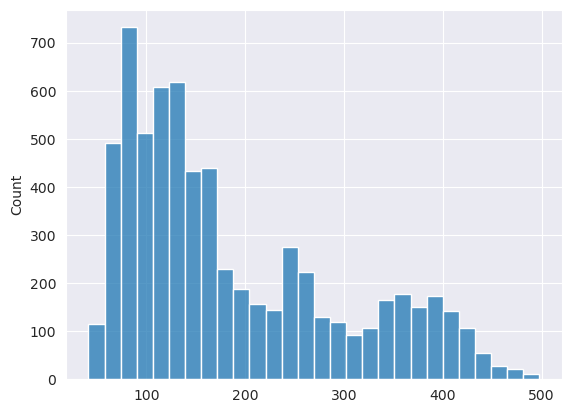

In [35]:
sns.histplot(y_pred)

In [37]:
data_test['price'] = y_pred

In [38]:
data_test

,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock,request_number,group,brand,parking,pool,children_policy,price
0,0,1,vilnius,21,romanian,0,1,161,46,1,Boss Western,J.Halliday Inn,1,0,0,112.317450
1,9,2,vilnius,18,romanian,0,1,161,36,2,Boss Western,J.Halliday Inn,1,0,0,111.623937
2,254,30,vilnius,20,romanian,1,12,161,44,1,Boss Western,J.Halliday Inn,1,0,0,111.493849
3,263,31,vilnius,18,romanian,1,12,161,36,2,Boss Western,J.Halliday Inn,1,0,0,112.682690
4,272,32,vilnius,16,bulgarian,0,12,161,30,3,Boss Western,J.Halliday Inn,1,0,0,113.653206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,5187,662,rome,39,slovene,1,771,856,39,1,Accar Hotels,Ibas,1,0,0,71.922692
6640,5426,693,rome,34,slovakian,1,514,856,26,1,Accar Hotels,Ibas,1,0,0,70.747590
6641,5920,753,rome,36,italian,0,768,856,31,1,Accar Hotels,Ibas,1,0,0,71.997737
6642,6350,811,rome,34,slovene,1,766,856,26,1,Accar Hotels,Ibas,1,0,0,72.039572


In [44]:
data.loc[data['avatar_id'] == 171]

,city,date,language,mobile,request_number,avatar_id,hotel_id,price,stock,group,brand,parking,pool,children_policy,SRprice
271645,sofia,17,greek,0,1,171,683,89,22,Chillton Worldwide,Tripletree,0,0,0,4.464745
271698,sofia,15,greek,0,2,171,683,89,16,Chillton Worldwide,Tripletree,0,0,0,4.464745
271717,sofia,14,greek,0,3,171,683,92,13,Chillton Worldwide,Tripletree,0,0,0,4.514357
271750,sofia,6,greek,0,4,171,683,90,0,Chillton Worldwide,Tripletree,0,0,0,4.481405
271768,sofia,17,greek,0,1,171,470,75,14,Independant,Independant,0,0,0,4.217163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281076,sofia,6,greek,0,4,171,871,89,0,Yin Yang,Ardisson,0,0,0,4.464745
281164,sofia,14,greek,0,3,171,899,104,14,Morriott International,CourtYord,0,0,0,4.702669
281194,sofia,6,greek,0,4,171,899,102,6,Morriott International,CourtYord,0,0,0,4.672329
281282,sofia,14,greek,0,3,171,262,104,10,Boss Western,J.Halliday Inn,1,0,0,4.702669


In [ ]:
592 788 171 239